<a href="https://colab.research.google.com/github/doronschwartz/NLP/blob/main/HW1/HW1_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
file_path = 'https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true'
israel = pd.read_excel(file_path)

In [5]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
file_path = 'https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true'
pal = pd.read_excel(file_path)

Convert to Lower Case, so all the words of same spelling but different case are one

In [6]:
israel_lower = israel.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [7]:
pal_lower = pal.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# MI

Finding words with high information gain, Where the data is vectorized, and then labeled from where it came from.

Using the built-in add, we are able to pull the MI and sort it nicely with the top ten.

In [9]:
from sklearn.feature_selection import mutual_info_classif

# Assign labels to each DataFrame
pal_lower['Label'] = 'Palestine'
israel_lower['Label'] = 'Israel'

# Concatenate the 'Content' columns and labels
all_text = pd.concat([pal_lower[['Content', 'Label']], israel_lower[['Content', 'Label']]])

# Use CountVectorizer to preprocess the text
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(all_text['Content'])

# Calculate mutual information for each word with respect to the labels
mutual_info = mutual_info_classif(X, all_text['Label'])

# Create a DataFrame with words and their corresponding mutual information scores
mi_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Mutual_Information': mutual_info})

# Sort the DataFrame by mutual information scores in descending order
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

# Display the top words with high mutual information
print(mi_df.head(10))



          Word  Mutual_Information
1817     hamas            0.100200
1697      gaza            0.096023
3166      read            0.067261
2159   israeli            0.066367
268        aje            0.064748
2134        io            0.064748
1954  hostages            0.048324
1952   hostage            0.042707
1967      http            0.042573
1078      deal            0.040385


Seeing these pass the logical test, it makes sense words like Hamas, and hostages can identify Israel, with hostage and ceasefire deal also providing higher MI.

# PMI between the words: Unsurpersived

With PMI, as it is unsupervised, we bring in the data again, unsupervised so it needs to be done independetly.

We will set a doc min to 30, and use the built in function to pull the Bigrams to provide the respect PMI

In [10]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk import collocations
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk import collocations
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))

# Function to perform tokenization and analysis
def analyze_dataframe(df):
    # Convert text to lowercase
    df_lower = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    # Extract the "Content" column for tokenization
    content_column = df_lower['Content']

    # Combine all text
    all_text = ' '.join(content_column.dropna())

    # Tokenize the text into words
    tokenized_documents = [
        [word for word in word_tokenize(doc) if word.isalnum() and word not in stop_words]
        for doc in content_column.dropna()
    ]

    # Use CountVectorizer to create a document-term matrix
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    dtm = vectorizer.fit_transform(tokenized_documents)

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Use NLTK's BigramCollocationFinder to find bigrams
    bigram_measures = collocations.BigramAssocMeasures()
    finder = collocations.BigramCollocationFinder.from_documents(tokenized_documents)

    # Calculate PMI for each bigram
    pmi_scores = {bigram: pmi for bigram, pmi in finder.score_ngrams(bigram_measures.pmi)}

    # Count document frequency of each bigram
    doc_freq = dtm.sum(axis=0)

    # Filter bigrams based on the specified document frequency threshold
    min_doc_freq = 30
    filtered_pmi_scores = {bigram: pmi for bigram, pmi in pmi_scores.items() if
                           doc_freq[0, vectorizer.vocabulary_[bigram[0]]] >= min_doc_freq and
                           doc_freq[0, vectorizer.vocabulary_[bigram[1]]] >= min_doc_freq}

    # Sort the filtered bigrams by PMI in descending order
    sorted_filtered_pmi_scores = sorted(filtered_pmi_scores.items(), key=lambda x: x[1], reverse=True)

    # Display the top N bigrams with the highest PMI and at least 30 documents
    top_n = 10
    for bigram, pmi in sorted_filtered_pmi_scores[:top_n]:
        print(f'Bigram: {bigram}, PMI: {pmi}, Document Frequency: {doc_freq[0, vectorizer.vocabulary_[bigram[0]]]}')

# Load dataframes
file_path_pal = 'https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true'
pal = pd.read_excel(file_path_pal)

file_path_israel = 'https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true'
israel = pd.read_excel(file_path_israel)

# Analyze each dataframe separately
print("Analysis for Pal:")
analyze_dataframe(pal)

print("\nAnalysis for Israel:")
analyze_dataframe(israel)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Analysis for Pal:
Bigram: ('occupation', 'forces'), PMI: 5.906890595608518, Document Frequency: 33
Bigram: ('genocide', 'gazagenocide'), PMI: 5.576772103067524, Document Frequency: 37
Bigram: ('gaza', 'strip'), PMI: 4.364028841380403, Document Frequency: 339
Bigram: ('israeli', 'forces'), PMI: 4.034125783904626, Document Frequency: 282
Bigram: ('israeli', 'occupation'), PMI: 3.963736456013228, Document Frequency: 282
Bigram: ('strip', 'http'), PMI: 3.937687111566248, Document Frequency: 52
Bigram: ('israeli', 'genocide'), PMI: 3.936180733492666, Document Frequency: 282
Bigram: ('israeli', 'bombardment'), PMI: 3.913612976587393, Document Frequency: 282
Bigram: ('palestinian', 'people'), PMI: 3.626081488046749, Document Frequency: 98
Bigram: ('palestinians', 'killed'), PMI: 3.5106042706268124, Document Frequency: 52

Analysis for Israel:


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Bigram: ('october', '7'), PMI: 6.924438796819366, Document Frequency: 52
Bigram: ('hostage', 'deal'), PMI: 6.18033113340914, Document Frequency: 55
Bigram: ('hostage', 'release'), PMI: 4.981022325185732, Document Frequency: 55
Bigram: ('netanyahu', 'said'), PMI: 4.920031695296585, Document Frequency: 34
Bigram: ('release', 'hostages'), PMI: 4.422532035825769, Document Frequency: 40
Bigram: ('deal', 'via'), PMI: 4.422532035825768, Document Frequency: 60
Bigram: ('deal', 'release'), PMI: 3.270528942380718, Document Frequency: 60
Bigram: ('deal', 'read'), PMI: 3.2526070343834554, Document Frequency: 60
Bigram: ('war', 'read'), PMI: 3.1822177064920574, Document Frequency: 63
Bigram: ('said', 'monday'), PMI: 3.100603940938406, Document Frequency: 30


Reviewing the above, the pal ones seem to be common palestenian phrases, with strip and http a bit awkward.

For Israel, much of the hostage discussion reveals itself. Clearly, many declarations were made on monday, with said and monday revealing to be significant.



# Bayes

The below code simply counts the phrases and gives the combined bayes factor. uses smoothing also.

In [12]:
file_path_pal = 'https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true'
pal = pd.read_excel(file_path_pal)

file_path_israel = 'https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true'
israel = pd.read_excel(file_path_israel)

pal_lower = pal.applymap(lambda x: x.lower() if isinstance(x, str) else x)

israel_lower = israel.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [13]:
from collections import Counter
import re

def compute_bayes_factor(word_counts1, word_counts2):
    """
    Compute Bayes Factor for each word.
    """
    return {word: (count1 + 1) / (word_counts2.get(word, 0) + 1) for word, count1 in word_counts1.items()}

def get_word_counts(df, min_occurrences=20):
    """
    Count occurrences of each word in the dataframe, filtering out words that occur less than min_occurrences times.
    Remove non-alphabet characters except for hashtags.
    """
    word_counts = Counter()
    pattern = re.compile(r'\b(?:\w+\#|\w+)\b')
    word_counts.update(word for content in df['Content'] for word in pattern.findall(content))

    # Filter out words that occur less than min_occurrences times
    return {word: count for word, count in word_counts.items() if count >= min_occurrences}


# Get word counts for each dataframe
word_counts_israel = get_word_counts(israel_lower)
word_counts_pal = get_word_counts(pal_lower)

# Compute Bayes Factor for each word
bayes_factors = compute_bayes_factor(word_counts_israel, word_counts_pal)

# Sort words by Bayes Factor
sorted_words = sorted(bayes_factors.items(), key=lambda x: x[1], reverse=True)

# Display results
for word, bf in sorted_words[:20]:
    print(f"Word: {word}, Bayes Factor: {bf}")


Word: hostages, Bayes Factor: 88.0
Word: read, Bayes Factor: 87.0
Word: idf, Bayes Factor: 85.0
Word: deal, Bayes Factor: 84.0
Word: 7, Bayes Factor: 77.0
Word: hostage, Bayes Factor: 77.0
Word: october, Bayes Factor: 57.0
Word: be, Bayes Factor: 57.0
Word: release, Bayes Factor: 51.0
Word: via, Bayes Factor: 43.0
Word: netanyahu, Bayes Factor: 41.0
Word: said, Bayes Factor: 39.0
Word: opinion, Bayes Factor: 36.0
Word: more, Bayes Factor: 34.0
Word: minister, Bayes Factor: 32.0
Word: monday, Bayes Factor: 32.0
Word: against, Bayes Factor: 31.0
Word: but, Bayes Factor: 30.0
Word: held, Bayes Factor: 30.0
Word: tuesday, Bayes Factor: 26.0


As we can hostages and 7 all have high Bayes factor, not many Pal words on the top here.

# Filtering

Taking a look at filtering some of the above functions and words a bit better with more stringent rules of what will be considered.

In [14]:
file_path_pal = 'https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true'
pal = pd.read_excel(file_path_pal)

file_path_israel = 'https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true'
israel = pd.read_excel(file_path_israel)

pal_lower = pal.applymap(lambda x: x.lower() if isinstance(x, str) else x)

israel_lower = israel.applymap(lambda x: x.lower() if isinstance(x, str) else x)

Below, we take out stop words, and porter stemmer and lemmatize the words, along with the originals.

With a MI and count document, we see worse and less intelligble results from the first MI. So this approach isnt great, which leads us to chi filtering after.

In [15]:
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

# Assign labels to each DataFrame
pal_lower['Label'] = 'Palestine'
israel_lower['Label'] = 'Israel'

# Combine both DataFrames
combined_df = pd.concat([israel_lower, pal_lower], ignore_index=True)

def preprocess_text(text):
    # Perform necessary preprocessing, e.g., lowercasing, stop word removal, stemming, etc.
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    words = re.findall(r'\b(?:\w+\#|\w+)\b', text.lower())  # Extract words and hashtags
    words = [word for word in words if word not in stop_words]  # Remove stop words

    # Include both stemmed and lemmatized versions along with the original words
    stemmed_words = [ps.stem(word) for word in words]  # Stemming
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization

    return words + stemmed_words + lemmatized_words

# Tokenize and preprocess the content
combined_df['Processed_Content'] = combined_df['Content'].apply(preprocess_text)

# Count the occurrences of each word in the processed content
word_counts = Counter(word for words in combined_df['Processed_Content'] for word in words)

# Calculate Mutual Information
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(combined_df['Processed_Content'])
mi_scores = mutual_info_classif(X, combined_df['Label'], discrete_features=True)

# Combine word counts and MI scores into a DataFrame
word_info_df = pd.DataFrame({'Word': list(word_counts.keys()), 'Count': list(word_counts.values()), 'MI_Score': mi_scores})

# Define thresholds or criteria for filtering
mi_threshold = 0.001  # Example threshold for MI score
count_threshold = 20 # Example threshold for word count

# Apply filtering based on criteria
filtered_words = word_info_df[(word_info_df['MI_Score'] > mi_threshold) & (word_info_df['Count'] > count_threshold)]

# Display results
print("Words filtered based on MI and Count:")
print(filtered_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Words filtered based on MI and Count:
          Word  Count  MI_Score
5          tel     33  0.001523
6         aviv     33  0.003662
7         last     88  0.001461
8         week     46  0.001461
11       hamas    537  0.002194
...        ...    ...       ...
4141      food     21  0.003089
4197       son     23  0.003662
4250  coverage     26  0.001461
4292       abu     33  0.002927
4570      tank     21  0.006612

[155 rows x 3 columns]


Chi Filtering

Taking the Chi2 distrubtion and applying to the words to get a sembelance of the distrubtion and see which words/phrases prove significant. Limited preprocessing applied

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from nltk.tokenize import word_tokenize  # Make sure to import this if not already done

# Apply lowercase and tokenization to 'Content' column
israel_lower['Content'] = israel_lower['Content'].apply(lambda x: ' '.join(word_tokenize(x.lower())))
pal_lower['Content'] = pal_lower['Content'].apply(lambda x: ' '.join(word_tokenize(x.lower())))

# Concatenate dataframes
df = pd.concat([israel_lower, pal_lower], ignore_index=True)

# Vectorize the 'Content' col'umn
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Content'])

# Calculate chi-squared statistics
chi2_stat, features = chi2(X, df['Label'])

# Create a DataFrame with features and chi2 statistics
chi2_df = pd.DataFrame({'feature': vectorizer.get_feature_names_out(), 'chi2_stat': chi2_stat})

# Get the top 40 features
top20_features = chi2_df.nlargest(50, 'chi2_stat')

# Print the top 40 features
print(top20_features)


           feature   chi2_stat
1816         hamas  181.954887
1953      hostages   87.000000
3165          read   86.000000
268            aje   83.000000
2133            io   83.000000
1951       hostage   76.000000
1078          deal   74.418605
271             al   73.923077
1994           idf   70.123596
2158       israeli   64.009756
1966          http   63.202247
1947      hospital   59.647059
1696          gaza   49.207143
3232       release   44.307692
606    bombardment   41.000000
631       breaking   39.185185
2153        israel   38.494033
1698  gazagenocide   37.000000
2798       opinion   35.000000
2753       october   32.060606
1713      genocide   30.857143
2747    occupation   30.117647
2689     netanyahu   29.454545
2586        monday   26.470588
2058    indonesian   25.137931
3209       refugee   24.142857
697           camp   22.533333
2186       jazeera   22.533333
3975       tuesday   22.153846
2135          iran   22.000000
2749      occupied   22.000000
3374    

The results speak for themselves, with hamas on the most. The results are mostly intelligible and are a quick way to show significance. Al is probably for Al Jazeera, though io is a bit of a mystery.

# Classifiers

Below, we will take the labeled data and run a simple classification of Multinomial Naive Bayes with k-fold. Feature Selection is not done explicitly.

In [32]:
import numpy as np
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load data for 'pal'
file_path_pal = 'https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true'
pal = pd.read_excel(file_path_pal)

# Load data for 'israel'
file_path_israel = 'https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true'
israel = pd.read_excel(file_path_israel)

# Convert the entire DataFrame to lowercase
pal_lower = pal.applymap(lambda x: x.lower() if isinstance(x, str) else x)
israel_lower = israel.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Assign labels to the data
pal_lower['label'] = 'Palestine'
israel_lower['label'] = 'Israel'

# Combine the dataframes
combined_data = pd.concat([pal_lower, israel_lower], ignore_index=True)

# Assuming you have a column named 'label'
X = combined_data['Content']
y = combined_data['label']

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Transform the data
X_vec = vectorizer.fit_transform(X)

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()

# Use 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_results = cross_val_score(classifier, X_vec, y, cv=kf, scoring='accuracy')

# Print the cross-validation results
print("Cross-validation results:")
print(cross_val_results)
print(f"Mean Accuracy: {np.mean(cross_val_results)}")


Cross-validation results:
[0.90526316 0.93684211 0.91578947 0.95789474 0.91578947 0.95789474
 0.91578947 0.90526316 0.92631579 0.95789474]
Mean Accuracy: 0.9294736842105262


The above results are 93%, lets see if playing with Feature Selection below will improve our results.

# Classifiers - Feature Selection

Below, we preprocess the data, and Train/Test split.

Then for a range of Features, we take the Cross Validation numbers to see which gives us the best results.

This time, we use the TFIDF vectorizer with Naive Bayes, and plot the results.

In [25]:
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Assign labels to each DataFrame
pal_lower['Label'] = 'Palestine'
israel_lower['Label'] = 'Israel'

# Combine both DataFrames
combined_df = pd.concat([israel_lower, pal_lower], ignore_index=True)

# Tokenize and preprocess the content
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = re.findall(r'\b(?:\w+\#|\w+)\b', text.lower())  # Extract words and hashtags
    words = [word for word in words if word not in stop_words]  # Remove stop words

    # Include both stemmed and lemmatized versions along with the original words
    stemmed_words = [ps.stem(word) for word in words]  # Stemming
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization

    return words + stemmed_words + lemmatized_words

combined_df['Processed_Content'] = combined_df['Content'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_df['Processed_Content'].apply(lambda x: ' '.join(x)),  # Convert list of words to space-separated string
    combined_df['Label'],
    test_size=0.2,
    random_state=42
)


In [26]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)

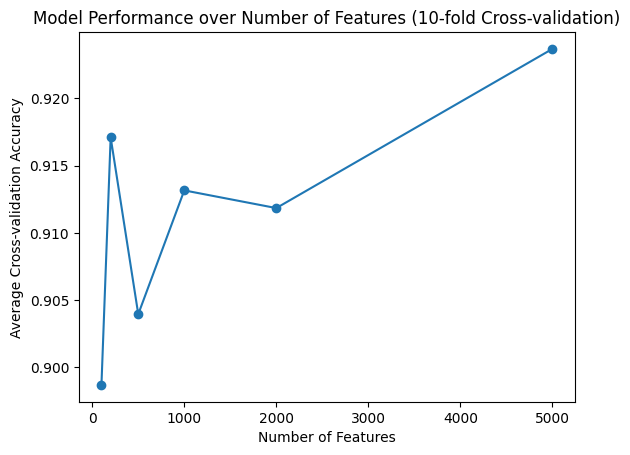

Maximum average cross-validation accuracy (92.37%) achieved with 5000 features.


In [30]:
# Function to train and evaluate the model with 10-fold cross-validation
def train_and_evaluate_model(X, y, vectorizer, feature_selector, classifier):
    # Vectorize the text
    X_vec = vectorizer.fit_transform(X)

    # Select features
    X_selected = feature_selector.fit_transform(X_vec, y)

    # Perform 10-fold cross-validation
    cross_val_scores = cross_val_score(classifier, X_selected, y, cv=10, scoring='accuracy')

    # Calculate the average cross-validation accuracy
    avg_cross_val_accuracy = cross_val_scores.mean()

    return avg_cross_val_accuracy

# Define a range of feature values to experiment with
feature_values = [100, 200, 500, 1000, 2000, 5000]

# Initialize vectors for storing results
avg_cross_val_accuracies = []

# Create vectorizer, feature selector, and classifier outside the loop
vectorizer = TfidfVectorizer()
feature_selector = SelectKBest(mutual_info_classif)
classifier = MultinomialNB()

# Iterate over different feature values
for num_features in feature_values:
    # Set the desired number of features
    feature_selector.set_params(k=num_features)

    # Train and evaluate the model with 10-fold cross-validation
    avg_cross_val_accuracy = train_and_evaluate_model(X_train, y_train, vectorizer, feature_selector, classifier)

    # Append the average cross-validation accuracy to the results vector
    avg_cross_val_accuracies.append(avg_cross_val_accuracy)

# Plot the results
plt.plot(feature_values, avg_cross_val_accuracies, marker='o')
plt.title('Model Performance over Number of Features (10-fold Cross-validation)')
plt.xlabel('Number of Features')
plt.ylabel('Average Cross-validation Accuracy')
plt.show()

# Find the maximum performance point
max_avg_cross_val_accuracy = max(avg_cross_val_accuracies)
optimal_num_features = feature_values[avg_cross_val_accuracies.index(max_avg_cross_val_accuracy)]
print(f"Maximum average cross-validation accuracy ({max_avg_cross_val_accuracy:.2%}) achieved with {optimal_num_features} features.")

Looking at the results, maxing out the features gave us the best Cross Validation Accuracy.

There is a strange dip at 500, which could be that selection of features caused overfitting.